In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, Add, Dot, Conv2DTranspose, Activation, Reshape, LeakyReLU, Flatten, BatchNormalization, Lambda, Softmax, Concatenate, Embedding, Multiply, Add
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.engine.base_layer import Layer, InputSpec
from keras.engine import *
from keras.legacy import interfaces
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils.generic_utils import func_dump
from keras.utils.generic_utils import func_load
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils
from keras.models import load_model

from time import time
import os
import functools
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from tensorflow.python.ops import array_ops
from skimage.transform import resize
from matplotlib import pyplot


Using TensorFlow backend.


All Convolutions with Spectral Normalization is defined here. Self Attention Gamma is defined here. Rest of Self Attention layers are defines as Lambda layers in generator and discriminator.

In [2]:

class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output 
        
class _ConvSN(Layer):

    def __init__(self, rank,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 spectral_normalization=True,
                 **kwargs):
        super(_ConvSN, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        self.spectral_normalization = spectral_normalization
        self.u = None
        
    def _l2normalize(self, v, eps=1e-12):
        return v / (K.sum(v ** 2) ** 0.5 + eps)
    
    def power_iteration(self, u, W):
        '''
        Accroding the paper, we only need to do power iteration one time.
        '''
        v = self._l2normalize(K.dot(u, K.transpose(W)))
        u = self._l2normalize(K.dot(v, W))
        return u, v
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        #Spectral Normalization
        if self.spectral_normalization:
            self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                     initializer=initializers.RandomNormal(0, 1),
                                     name='sn',
                                     trainable=False)
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        
        if self.spectral_normalization:
            W_shape = self.kernel.shape.as_list()
            #Flatten the Tensor
            W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
            _u, _v = power_iteration(W_reshaped, self.u)
            #Calculate Sigma
            sigma=K.dot(_v, W_reshaped)
            sigma=K.dot(sigma, K.transpose(_u))
            #normalize it
            W_bar = W_reshaped / sigma
            #reshape weight tensor
            if training in {0, False}:
                W_bar = K.reshape(W_bar, W_shape)
            else:
                with tf.control_dependencies([self.u.assign(_u)]):
                    W_bar = K.reshape(W_bar, W_shape)

            #update weitht
            self.kernel = W_bar
        
        if self.rank == 1:
            outputs = K.conv1d(
                inputs,
                self.kernel,
                strides=self.strides[0],
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
        if self.rank == 2:
            outputs = K.conv2d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.rank == 3:
            outputs = K.conv3d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)

    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(_Conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
      
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    

class ConvSN2DTranspose(Conv2DTranspose):

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (self.filters, input_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.filters]),
                        initializer=initializers.RandomNormal(0, 1),
                        name='sn',
                        trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True  
    
    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(dim_size = height,
                                                    kernel_size = kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride_size=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_length(dim_size = width,
                                                    kernel_size = kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride_size=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)   
        #Spectral Normalization    
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-2]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.kernel = W_bar
        
        outputs = K.conv2d_transpose(
            inputs,
            self.kernel,
            output_shape_tensor,
            self.strides,
            padding=self.padding,
            data_format=self.data_format)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs



class SelfAttentionGamma(Layer):

    def __init__(self,
                 **kwargs):
        super(SelfAttentionGamma, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        self.gamma = self.add_weight(shape=[1],
                                         name='gamma',
                                         initializer='zeros')
        self.built = True

    def call(self, inputs, training=None):
        # print(inputs[1].shape.as_list())
        # print(inputs[0].shape.as_list())
        return self.gamma*K.reshape(inputs[1], shape = K.shape(inputs[0])) + inputs[0]

    def get_config(self):
        config = {
        }
        base_config = super(SelfAttentionGamma, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        return input_shape[0]

In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

import datasets

In [4]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

All hyperparameters

In [5]:
#Hyperperemeter
BATCHSIZE=64
FID_BATCH_SIZE= 64
LEARNING_RATE = 0.0002
LEARNING_RATE_G = 0.0001
LEARNING_RATE_D = 0.0002
BETA_1 = 0
BETA_2 = 0.9
EPOCHS = 600
BN_MIMENTUM = 0.1
BN_EPSILON  = 0.0002
model_save_interval = 1
fid_eval_steps = 1000

Save Directories

In [6]:
## Change save paths as required
SAVE_IMG_DIR = 'C:\\Users\\parit\\Documents\\DeepLearning\\finalconditional500to600\\img\\'
SAVE_LOGS_DIR = 'C:\\Users\\parit\\Documents\\DeepLearning\\finalconditional500to600\\logs\\'
SAVE_LOSS_FID_LOGS = 'C:\\Users\\parit\\Documents\\DeepLearning\\finalconditional500to600\\fid_logs\\'
model_save_dir = 'C:\\Users\\parit\\Documents\\DeepLearning\\finalconditional500to600\\models\\'

Define Losses - Used Hinge Loss

In [7]:
def hinge_G_loss(y_true, y_pred):
    return -K.mean(y_pred)

def hinge_D_real_loss(y_true, y_pred):
    return K.mean(K.relu(1-y_pred))

def hinge_D_fake_loss(y_true, y_pred):
    return K.mean(K.relu(1+y_pred))

In [8]:
def mult1(x):
    x1 = x[0]
    x2 = x[1]
    x3 = K.permute_dimensions(x[1],pattern=(0,2,1))
    x4 = K.batch_dot(x1, x3, axes=(2,1))
    return x4

Generator Model

In [9]:
 def BuildGenerator():

    label = Input(shape=(10,))
    noise = Input(shape=(128,))
    ## Mask created in expection of usefulness at a later stage. Initiliazed with all ones.
    mask = Input(shape=(16*16, 16*16)) 

    merge = Concatenate(name = 'l4')([noise, label])
    net = Dense(4*4*512, kernel_initializer='glorot_uniform', name = 'l5')(merge)
    net = Reshape((4,4,512), name = 'l6')(net)
    net = ConvSN2DTranspose(256, kernel_size=4, strides=2, padding='same', kernel_initializer='glorot_uniform', activation = None, name = 'l7')(net)
    net = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM, name = 'l8')(net)
    net = Activation('relu', name = 'l9')(net)
    net = ConvSN2DTranspose(128, kernel_size=4, strides=2, padding='same', kernel_initializer='glorot_uniform',activation = None, name = 'l10')(net)
    net = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM, name = 'l11')(net)
    net = Activation('relu', name = 'l12')(net)

    #Self Attention
    
    SAop_f = ConvSN2D(128//8, kernel_size=1, strides=1,kernel_initializer='glorot_uniform', padding='same', activation=None)(net)
    # print(SAop_f.shape.as_list())
    SAop_f_re = Lambda(lambda x:K.reshape(x, shape = (K.shape(x)[0], -1,K.shape(x)[3])))(SAop_f)
    # print(SAop_f_re.shape.as_list())
    SAop_g = ConvSN2D(128//8, kernel_size=1, strides=1,kernel_initializer='glorot_uniform', padding='same', activation=None)(net)
    SAop_g_re = Lambda(lambda x:K.reshape(x, shape = (K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2],K.shape(x)[-1])))(SAop_g)
    SAop_h = ConvSN2D(128, kernel_size=1, strides=1,kernel_initializer='glorot_uniform', padding='same', activation=None)(net)
    SAop_h_re = Lambda(lambda x:K.reshape(x, shape = (K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2],K.shape(x)[-1])))(SAop_h)
    mult = Lambda(lambda x:mult1(x))([SAop_g_re, SAop_f_re])
    # print(mult.shape.as_list())
    attnmap = Softmax(axis=-1)(mult)
    attnmapsel = Multiply()([attnmap, mask])
    # print(attnmap.shape.as_list())
    SAop = Lambda(lambda x:K.batch_dot(x[0], x[1], axes=(2, 1)))([attnmapsel, SAop_h_re])
    # print(SAop.shape.as_list())
    SAop_final = SelfAttentionGamma()([net, SAop])

    net = ConvSN2DTranspose(64,  kernel_size=4, strides=2, padding='same', kernel_initializer='glorot_uniform',activation = None, name = 'l15')(SAop_final)
    net = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM, name = 'l16')(net)
    net = Activation('relu', name = 'l17')(net)
    op = ConvSN2DTranspose(3,   kernel_size=3, strides=1, padding='same', activation='tanh', name = 'l18')(net)
    gen_model = Model([noise, label, mask], op)
    attnmap_model = Model([noise, label], attnmap)
    gen_model.summary()
    return gen_model, attnmap_model


Discriminator Model

In [10]:
def BuildDiscriminator():

    label = Input(shape=(10,))
    img = Input(shape=(32,32,3))
    net = ConvSN2D(64, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(img)
    net = LeakyReLU(0.1)(net)
    net = ConvSN2D(64, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)

    net = ConvSN2D(128, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)

     #Self Attention
    
    SAop_f = ConvSN2D(128//8, kernel_size=1, strides=1,kernel_initializer='glorot_uniform', padding='same', activation=None)(net)
    # print(SAop_f.shape.as_list())
    SAop_f_re = Lambda(lambda x:K.reshape(x, shape = (K.shape(x)[0], -1,K.shape(x)[3])))(SAop_f)
    # print(SAop_f_re.shape.as_list())
    SAop_g = ConvSN2D(128//8, kernel_size=1, strides=1,kernel_initializer='glorot_uniform', padding='same', activation=None)(net)
    SAop_g_re = Lambda(lambda x:K.reshape(x, shape = (K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2],K.shape(x)[-1])))(SAop_g)
    SAop_h = ConvSN2D(128, kernel_size=1, strides=1,kernel_initializer='glorot_uniform', padding='same', activation=None)(net)
    SAop_h_re = Lambda(lambda x:K.reshape(x, shape = (K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2],K.shape(x)[-1])))(SAop_h)
    mult = Lambda(lambda x:mult1(x))([SAop_g_re, SAop_f_re])
    # print(mult.shape.as_list())
    attnmap = Softmax(axis=-1)(mult)
    # print(attnmap.shape.as_list())
    SAop = Lambda(lambda x:K.batch_dot(x[0], x[1], axes=(2, 1)))([attnmap, SAop_h_re])
    # print(SAop.shape.as_list())
    SAop_final = SelfAttentionGamma()([net, SAop])

    
    net = ConvSN2D(128, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same')(SAop_final)
    net = LeakyReLU(0.1)(net)

    net = ConvSN2D(256, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)
    net = ConvSN2D(256, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)

    net = ConvSN2D(512, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)
    net = Flatten()(net)
    
    merged_layer = Concatenate()([net, label])
    net = DenseSN(512, activation='relu')(merged_layer)
    
    op  = DenseSN(1,kernel_initializer='glorot_uniform')(net)
    
    model = Model([img, label], op)
    model.summary()
    return model

Discriminator Training Model and Generator training model

In [11]:
def Buildgan(generator, discriminator):
    Real_image                             = Input(shape=(32,32,3))
    Real_label                             = Input(shape = (10,))
    Noise, Fake_label, mask                = generator.input
    Fake_image                             = generator([Noise, Fake_label, mask])
    Discriminator_output_for_real          = discriminator([Real_image, Real_label])
    Discriminator_output_for_fake          = discriminator([Fake_image, Fake_label])

    model_for_training_discriminator       = Model([Real_image, Real_label,
                                                    Noise, Fake_label, mask],
                                                   [Discriminator_output_for_real,
                                                    Discriminator_output_for_fake])
    gan                                    = Model([Noise, Fake_label, mask], Discriminator_output_for_fake)
    return model_for_training_discriminator, gan

Build all models

In [12]:
generator, attentionmap = BuildGenerator()
discriminator = BuildDiscriminator()
model_for_training_discriminator, gan = Buildgan(generator, discriminator)







__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
l4 (Concatenate)                (None, 138)          0           input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
l5 (Dense)                      (None, 8192)         1138688     l4[0][0]                         
____

Load weights for training continuation from previous point

In [13]:
generator.load_weights("SAGAN_generator_model_weights.h5")
discriminator.load_weights("SAGAN_discriminator_model_weights.h5")
model_for_training_discriminator.load_weights("SAGAN_model_for_training_discriminator_model_weights.h5")
gan.load_weights("SAGAN_gan_model_weights.h5")

Compile all models

In [14]:
generator.trainable = False
discriminator.trainable = True
model_for_training_discriminator.compile(optimizer=Adam(LEARNING_RATE_D, beta_1=BETA_1, beta_2=BETA_2), loss=[hinge_D_real_loss, hinge_D_fake_loss])
model_for_training_discriminator.summary()
discriminator.trainable = False
generator.trainable = True
gan.compile(optimizer=Adam(LEARNING_RATE_G, beta_1=BETA_1, beta_2=BETA_2), loss=hinge_G_loss)
gan.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256)     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_7 (

Utility Functions

In [15]:
def label_gen():
    label = np.zeros(shape = 100, dtype = 'int32')
    for i in range(0,10):
        for j in range(0, 10):
            label[10*i + j] = i
    return label

def one_hot_encode(y):
    z = np.zeros((len(y), 10))
    idx = np.arange(len(y))
    z[idx, y] = 1
    return z

def generate_random_labels(n):
    y = np.random.choice(10, n)
    y = one_hot_encode(y)
    return y

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [16]:
real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = -real_y
X = x_train
X = X/255*2-1
true_label = one_hot_encode(y_train[:,0])
fid_test_label = one_hot_encode(y_test[:,0])

FID related Functions. Calculate mean and variance of validated image datasets.

In [17]:
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

def inception_activations(images):
    size = 299
    images = images.astype('float32')
    images = scale_images(images, (299,299,3))
    images = preprocess_input(images)
    activations = inception.predict(images)
    return activations

def get_inception_activations(inps):
    n_batches = int(np.ceil(float(inps.shape[0]) / FID_BATCH_SIZE))
    act = np.zeros([inps.shape[0], 2048], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * FID_BATCH_SIZE : (i + 1) * FID_BATCH_SIZE]
        act[i * FID_BATCH_SIZE : i * FID_BATCH_SIZE + min(FID_BATCH_SIZE, inp.shape[0])] = inception_activations(inp)
    return act

# test images statistics
f1 = get_inception_activations(x_test)
mean1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)

save model functions

In [18]:

def save_models(generator, discriminator, gan, model_for_training_discriminator, epoch_no, model_save_dir = model_save_dir):
        discriminator.trainable = True
        save_model(discriminator, model_save_dir + 'discriminator_model', epoch_no)
        generator.trainable = False
        save_model(model_for_training_discriminator, model_save_dir + 'model_for_training_discriminator', epoch_no)
        generator.trainable = True
        save_model(generator, model_save_dir + 'generator_model', epoch_no)
        discriminator.trainable = False
        save_model(gan, model_save_dir + 'gan_model', epoch_no)
        
def save_model(model, model_path, epoch_no):
        with open(str(model_path) + '_' + str(epoch_no) + '.json', 'w') as json_file:
            json_file.write(model.to_json())

        with open(str(model_path) + '.json', 'w') as json_file:
            json_file.write(model.to_json())
            
        model.save_weights(str(model_path + '_' + "weights_" + str(epoch_no) + '.h5'))
        model.save_weights(str(model_path + '_' + "weights" + '.h5'))
        
        model.save(str(model_path+ '.h5'))  # creates a HDF5 file 'my_model.h5'


plot functions

In [19]:
def save_plot(images, epoch, path, n=10):
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)
    for i in range(100):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
    plt.savefig(path+'cGAN_{:05d}.png'.format(epoch))
    plt.close()

def plot_images(x, imgsize, batch_size=100):
    fig = plt.figure(figsize=(imgsize,imgsize))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)
    for i in range(batch_size):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(x[i], cmap='gray')

Attention Map visualization functions

In [20]:
def getattentionmapandimage(noise, label, attnmask):
    attn_map = attentionmap.predict([noise, label])
    gen_img = generator.predict([noise, label, attnmask])
    return attn_map, gen_img
        
def visualizeattentionmaps(attn_map, loc):                       
    a = np.reshape(attn_map[0][loc],(16,16))  ## 128th attention vector is shown
    b = np.zeros((1,16, 16), dtype = 'float64')
    b[0,:,:] = a
    c = scale_images(b, (32, 32))       
    plot_images(c, 10, 1)

Run this cell only for training

In [ ]:
img_gen_noise = np.random.randn(100, 128)
img_gen_label = np.tile(np.eye(10), [10, 1])
img_gen_attnmask = np.ones((100, 16*16, 16*16), dtype=np.float32)


attnmask = np.ones((BATCHSIZE, 16*16, 16*16), dtype=np.float32)

fid_attnmask = np.ones((500, 16*16, 16*16), dtype=np.float32)
D_real = []
D_fake = []
D_loss = []
G_loss = []

d_real_perepoch = []
d_fake_perepoch = []
d_loss_perepoch = []
g_loss_perepoch = []

FID = []
fid = 0
counter = 0

logs_loss = open(SAVE_LOGS_DIR + "logs_" + str(22) + ".txt", 'a')

for epoch in range(EPOCHS):
    
    X_shuffled, true_label_shuffled = unison_shuffled_copies(X, true_label)
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X_shuffled.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(X_shuffled.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(X_shuffled.shape[0] // (BATCHSIZE)), width=20)
    
    start_time = time()
    for index in range(int(X_shuffled.shape[0] // (BATCHSIZE))):
        progress_bar.update(index)
        image_batch = X_shuffled[index * BATCHSIZE:(index + 1) * BATCHSIZE]
        label_batch = true_label_shuffled[index * BATCHSIZE:(index + 1) * BATCHSIZE]
        
        noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
        
        discriminator.trainable = True
        generator.trainable = False
        generated_image = generator.predict([noise, label_batch, attnmask])
        # print(generated_image.shape)
        err_real, err_fake, s_err = model_for_training_discriminator.train_on_batch([image_batch, label_batch, noise, label_batch, attnmask], [real_y, fake_y])

        err_total = (err_real + err_fake)
        D_loss.append(err_total)
        D_real.append(err_real)
        D_fake.append(err_fake)
        discriminator.trainable = False
        generator.trainable = True
        
        random_labels = generate_random_labels(BATCHSIZE)
        err_g = gan.train_on_batch([np.random.randn(BATCHSIZE, 128), random_labels, attnmask], real_y)
        G_loss.append(err_g)
        logs_loss.write(str(err_real) + '\t' + str(err_fake) + '\t' + str(err_total) + '\t' + str(err_g) + '\n')
        counter +=1       
        
        if(np.mod(counter, fid_eval_steps) == 0):
            samples = np.zeros((10000, 32, 32, 3))
            n_batches = 20
            lo = 0
            for btch in range(n_batches):
                noise_fid = np.random.randn(500, 128)
                samples[lo:(lo+500)] = generator.predict([noise_fid, fid_test_label[lo:(lo+500)], fid_attnmask])
                lo += 500

            samples = (samples + 1.) * 127.5
            
            f2 = get_inception_activations(samples)
            mean2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
            sum_sq_diff = np.sum((mean1 - mean2)**2)
            cov_mean = sqrtm(sigma1.dot(sigma2))
            if np.iscomplexobj(cov_mean):
                cov_mean = cov_mean.real
            fid = sum_sq_diff + np.trace(sigma1 + sigma2 - 2.0*cov_mean)
            
            FID.append(fid)
            logs_loss.write(str(err_real) + '\t' + str(err_fake) + '\t' + str(err_total) + '\t' + str(err_g) + '\t' + str(fid) + '\n')

    if ((epoch+1) % model_save_interval) == 0:
            save_models(generator, discriminator, gan, model_for_training_discriminator, epoch, model_save_dir)
    
    print('\nepoch time: {}'.format(time()-start_time))
    print("fid: {}".format(fid))
    d_real_perepoch.append(err_real)
    d_fake_perepoch.append(err_fake)
    d_loss_perepoch.append(err_total)
    g_loss_perepoch.append(err_g)

    print("d_real_loss:{} d_fake_loss:{} d_loss:{} g_loss:{}".format(d_real_perepoch[-1], d_fake_perepoch[-1], d_loss_perepoch[-1], g_loss_perepoch[-1]))
        #Generate image
    generated_image = generator.predict([img_gen_noise, img_gen_label, img_gen_attnmask])
    generated_image = (generated_image + 1)/2.
    
    save_plot(generated_image, epoch, SAVE_IMG_DIR, 10)
    
logs_loss.close()

Attention Map visualization

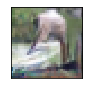

In [27]:
weightspath = "SAGAN_generator_model_weights.h5"  
generator.load_weights(weightspath)
img_gen_noise = np.random.randn(1, 128)
img_gen_label = one_hot_encode([7]) ## 7 is class no. Can be [0,9]
img_gen_attnmask = np.ones((1, 16*16, 16*16), dtype=np.float32)
attn_map, generated_image = getattentionmapandimage(img_gen_noise, img_gen_label, img_gen_attnmask)
generated_image = (generated_image + 1 )/2.
plot_images(generated_image, 10, 1)

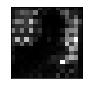

In [28]:
# Visulation Attention of ith location
visualizeattentionmaps(attn_map, 100) ##128 is location. Can be [0,255]

Run this cell for testing

FID: 22.942466233192413


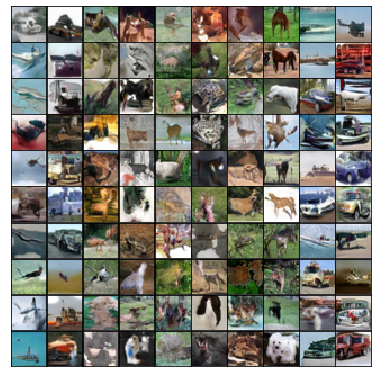

In [22]:

weightspath = "SAGAN_generator_model_weights.h5"
generator.load_weights(weightspath)
img_gen_noise = np.random.randn(100, 128)
img_gen_label = np.tile(np.eye(10), [10, 1])
img_gen_attnmask = np.ones((100, 16*16, 16*16), dtype=np.float32)

generated_image = generator.predict([img_gen_noise, img_gen_label, img_gen_attnmask])
generated_image = (generated_image + 1)/2.
plot_images(generated_image, 5, 100)

print("calculating FID")
fid_attnmask = np.ones((500, 16*16, 16*16), dtype=np.float32)
samples = np.zeros((10000, 32, 32, 3))
n_batches = 20
lo = 0
for btch in range(n_batches):
    noise_fid = np.random.randn(500, 128)
    samples[lo:(lo+500)] = generator.predict([noise_fid, fid_test_label[lo:(lo+500)], fid_attnmask])
    lo += 500

samples = (samples + 1.) * 127.5

f2 = get_inception_activations(samples)
mean2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
sum_sq_diff = np.sum((mean1 - mean2)**2)
cov_mean = sqrtm(sigma1.dot(sigma2))
if np.iscomplexobj(cov_mean):
    cov_mean = cov_mean.real
fid = sum_sq_diff + np.trace(sigma1 + sigma2 - 2.0*cov_mean)
print("FID: {}".format(fid))